# Library Imports

In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import gvar as gv
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(1, '../')
from building_blocks_reader import bulding_block

In [10]:
#!pip install -e /wsgjsc/home/taggi1/workspace_folders/CorrelatorAnalyser

In [2]:
#!pip install mplStyle

## Pasted from available code

In [2]:
from dataclasses import dataclass
from pathlib import Path
import json
import itertools
import h5py as h5 
import numpy as np
import gvar as gv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import json
from tqdm import tqdm

import sys

#sys.path.insert(1, '../../CorrelatorAnalyser')
sys.path.insert(1, '/wsgjsc/home/taggi1/workspace_folders/CorrelatorAnalyser')


import correlatoranalyser as ca

#from lib_ensembleDetails import EnsembleDetails

#from mplStyle import *

# %matplotlib ipympl
%matplotlib inline

markers = [".","+","^","s","p","*","h","v","x","<",">","D","o"]
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0,(1,10)), (5,(10,13))]

In [ ]:
#with h5.File("Cache/D251_Nbst100.h5", 'r') as h5f:
#    params = json.loads(
#        h5f["Meta"][()]
#    )

# I want to adept some naming conventions
params["C2pt fit"] = {
    "shared": {
        "min interval start": 1,
        "interval end"      : 50,
        "interval step"     : 4,
        
        "max number states": 2,
        "model" : "sum of ordered exponentials",
        
        "central value fit": True,            
        "central value fit correlated": False, 
        "resample fit": True,     
        "resample fit correlated": False,      
        "resample prior": False,

        "prior strategy": {
            "Eeff": {
                "estimate range start": 15,
                "estimate range stop" : 50
            },
            "std scale": 3,
            "mpi": gv.gvar("0.09203(16)")
        }
    }
}

In [ ]:
def effective_energy(C2pt, q2):
    logC = np.log(np.abs(C2pt[q2]))
    
    E_eff = 0.5*( np.roll(logC, +1, axis=-1) - np.roll(logC, -1, axis=-1 ) )[...,1:-1]

    return E_eff

#Eeff_unpolarized = {
#    f"q2: {q2}": effective_energy(C2pt_unpolarized, q2)
#        for q2 in range(params["maximal momentum squared"]+1)
#}

NameError: name 'params' is not defined

In [6]:
class SumOrderedExponentials:
    def __init__(self, number_states):
        self.number_states = number_states

    def __call__(self,t,p):
        E = p["E0"]
        out = p[f"A{0}"] * np.exp( -t*E )
    
        for n in range(1,self.number_states):
            #    ΔE_n = E_n - E_{n-1}
            # =>  E_n = E_{n-1} + ΔE_n
            E += p[f"dE{n}"]
    
            out += p[f"A{n}"] * np.exp( -t*E )
    
        return out

In [ ]:
def model_average_prior(fit_state, key, fit_task):
    r"""

    """
    
    # determine if we desire a log prior
    log_prior = 'log' in key

    # prepare the key to access the exponentiated result extracted of the model average
    if log_prior:
        key = key[4:-1]

    # compute the model average
    model_average = fit_state.model_average()

    # ensure that the key is in the model average and if not return a flat prior
    if key not in model_average['est'].keys():
        raise RuntimeError(f"{key} not yet fitted, choose different prior strategy")

    # prior rule: N( <p>, X*std(p) )
    prior = gv.gvar(
        model_average['est'][key],
        #np.maximum(
        #    Args['est']["A00"],
        model_average['err'][key] * fit_task["prior strategy"]["std scale"]
        #)
    )

    if log_prior:
        return gv.log(prior)
    else:
        return prior


def prior_sum_ordered_exponentials(NumberStates, q2, params, **kwargs):
    prior = gv.BufferDict()

    if f"q2: {q2}" in params["C2pt fit"].keys():
        fit_task = params["C2pt fit"][f"q2: {q2}"]
    else:
        fit_task = params["C2pt fit"]["shared"]    
    
    if "fit_state" in kwargs.keys():
        fit_state = kwargs["fit_state"]
            
        prior["A0"] = model_average_prior(fit_state = fit_state, key = "A0", fit_task = fit_task)
        prior["E0"] = model_average_prior(fit_state = fit_state, key = "E0", fit_task = fit_task)
        
        for n in range(1,NumberStates):
            for key in [f"dE{n}", f"A{n}"]:
                if key not in fit_state.keys_all:
                    prior[key] = gv.gvar(1,1000)
                else:
                    prior[key] = model_average_prior(fit_state = fit_state, key = key, fit_task = fit_task)
                
        return prior

    linear_fit_result = one_state_solution[f"q2: {q2}"].result_params()
    
    prior["A0"] = gv.gvar(
               np.exp( gv.mean(linear_fit_result["est"]["ln(A0)"])),
        np.std(np.exp( gv.mean(linear_fit_result["res"]["ln(A0)"])), axis =0 ) * fit_task["prior strategy"]["std scale"]
    )
    prior["E0"] = gv.gvar(
        linear_fit_result["est"]["E0"],
        linear_fit_result["err"]["E0"] * fit_task["prior strategy"]["std scale"]
    )

    C = C2pt_unpolarized[q2]
    C = gv.gvar( np.mean(C,axis=0), np.std(C,axis=0) ) 

    for n in range(1,NumberStates):
        
        if n == 1:
            prior[f"log(dE1)"]= gv.log(gv.gvar(
                gv.mean(prior[f"E0"] + fit_task["prior strategy"]["mpi"]),
                gv.mean(prior[f"E0"] + fit_task["prior strategy"]["mpi"]),
            ))

            t_probe = 1
            tmp = (C[t_probe] - prior["A0"] * np.exp(-t_probe*prior["E0"]) ) * np.exp( t_probe * ( prior["dE1"] + prior["E0"]) )
            prior[f"A1"] = gv.gvar( 
                gv.mean(tmp),gv.mean(tmp)
            )
        else:
            prior[f"A{n}"] = gv.gvar(1,1000)
            prior[f"log(dE{n})"] = gv.log(gv.gvar(1,1))

    return prior

models = {
    "sum of ordered exponentials": (SumOrderedExponentials, prior_sum_ordered_exponentials),
}

In [ ]:
def fit_C2pt(C2pt, q2, params, pbar):
    if f"q2: {q2}" in params["C2pt fit"].keys():
        fit_task = params["C2pt fit"][f"q2: {q2}"]
    else:
        fit_task = params["C2pt fit"]["shared"]

    fit_state = ca.FitState()

    C = C2pt[q2] 
    
    for number_states in range(1, fit_task["max number states"]+1):
        number_params = 2 * number_states

        model = models[fit_task["model"]][0](number_states)

        num_fits = 0 
        for ts in range(fit_task["min interval start"], fit_task["interval end"], fit_task["interval step"]):
            if (fit_task["interval end"]-ts <= number_params+2 ): continue
            
            te = fit_task["interval end"]

            if num_fits > 4:
                prior = models[fit_task["model"]][1](number_states, q2, params, fit_state = fit_state)
            else:
                prior = models[fit_task["model"]][1](number_states, q2, params)

            if number_states == 1:
                fit_result = ca.linear_regression(
                    abscissa                = np.arange(ts,te),
                    ordinate_est            = np.mean(np.log(np.abs(C[:,ts:te])), axis = 0),
                    ordinate_std            = np.std (np.log(np.abs(C[:,ts:te])), axis = 0),
                    ordinate_cov            = np.cov (np.log(np.abs(C[:,ts:te])), rowvar=False),
                    resample_ordinate_est   = np.log(np.abs(C[:,ts:te])),
                    resample_ordinate_std   = np.std (np.log(np.abs(C[:,ts:te])), axis = 0),
                    resample_ordinate_cov   = np.cov (np.log(np.abs(C[:,ts:te])), rowvar=False),
                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = fit_task["central value fit"],
                    central_value_fit_correlated = fit_task["central value fit correlated"],
                    resample_fit                 = fit_task["resample fit"],
                    resample_fit_correlated      = fit_task["resample fit correlated"],
                    resample_type               = "bst" if params["bootstrap"] else "jkn",
                    
                    has_intercept = True,
                    parameter_names = ["E0", "log(A0)"]
                )
                fit_result.fcn = SumOrderedExponentials(number_states = 1)
                
            else:
                fit_result = ca.fit(
                    abscissa                = np.arange(ts,te),
                    ordinate_est            = np.mean(C[:,ts:te], axis = 0),
                    ordinate_std            = np.std (C[:,ts:te], axis = 0),
                    ordinate_cov            = np.cov (C[:,ts:te], rowvar=False),
                    resample_ordinate_est   = C[:,ts:te],
                    resample_ordinate_std   = np.std (C[:,ts:te], axis = 0),
                    resample_ordinate_cov   = np.cov (C[:,ts:te], rowvar=False),
                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = fit_task["central value fit"],
                    central_value_fit_correlated = fit_task["central value fit correlated"],
                    resample_fit                 = fit_task["resample fit"],
                    resample_fit_correlated      = fit_task["resample fit correlated"],
                    resample_fit_resample_prior  = fit_task["resample prior"],
                    resample_type               = "bst" if params["bootstrap"] else "jkn",
                    # args for lsqfit:
                    model   = model,
                    prior   = prior,
                    p0      = None,
                    svdcut  = None,
                    maxiter = 10_000,
                )

            num_fits+=1

            pbar.write(f"{fit_result}")

            fit_state.append(fit_result)
            pbar.update()
        # end for ts
    # end for number_states
    return fit_state

# Data Reading

In [10]:
#folders where the dataset is
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/3PointCorrelation/T6/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/2PointCorrelation/"

#instance of the building block class
bb = bulding_block(p3fold,p2fold, maxConf=100, verbose=True, skip3p=True)


Initializing the building block class instance...


Looping over the configurations to read the building blocks from the h5 files...


Looping over the configurations to read the 2-point correlators from the h5 files...



100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


In [7]:
bb.latticeT

times = np.arange(bb.latticeT)

48

In [11]:
p2corr = bb.p2_corr.real

np.shape(p2corr)

(100, 48)

In [ ]:
#fit parameters

# abscissa = arange(t_start_plateau, t_end_plateau)

# ordinate_est = mean(p2corr, axis=cfg )    #-----> everything performed on log of abs of p2corr, not p2corr itself, if regression is used instead of fit
# ordinate_std = std(p2corr, axis=cfg ) 
# ordinate_cov = cov(p2corr, axis=cfg ) 

# resample_ordinate_est = p2corr #----------> axis 0 = cfg or axis 0 = resample ???
# resample_ordinate_std = ordinate_std
# resample_ordinate_cov = ordinate_cov

# central_value fit = bool, related to type of fit (True by default)
# central_value_fit_correlated = bool, related to type of fit (False by default)

# resample_fit                 =  bool, related to type of fit (False by default)
# resample_fit_correlated      =  bool, related to type of fit (False by default)

# resample_fit_resample_prior  =  bool, related to type of fit (True by default) #----> might want to put that to False to make running time shorter while developing
# resample_type               = "bst" if bootstrap is used else "jkn" if jackknife is used

# model = function taking as input abscissa and fit params

# prior = prior estimate of fit params

# p0 = start value of fit params

# maxiter = max n of iterations for the fit

# svdcut = ???

In [ ]:
#params["C2pt fit"] = {
#    "shared": {
#        "min interval start": 1,
#        "interval end"      : 50,
#        "interval step"     : 4,
#        
#        "max number states": 2,
#        "model" : "sum of ordered exponentials",
#        
#        "central value fit": True,            
#        "central value fit correlated": False, 
#        "resample fit": True,     
#        "resample fit correlated": False,      
#        "resample prior": False,
#
#        "prior strategy": {
#            "Eeff": {
#                "estimate range start": 15,
#                "estimate range stop" : 50
#            },
#            "std scale": 3,
#            "mpi": gv.gvar("0.09203(16)")
#        }
#    }
#}

In [12]:
#ca.fit(abscissa=times)

# Effective Mass Plateau

In [ ]:
from moments_toolkit import effective_mass, jackknife, plateau_search

In [105]:
#we determine log of 2p corr using the jackknife
p2corr_jack, p2corr_jack_std, p2corr_jack_cov = jackknife(p2corr, lambda x: np.mean( x, axis=0), jack_axis=0, time_axis=-1)

np.shape(p2corr_jack)
np.shape(p2corr_jack_std)
np.shape(p2corr_jack_cov)

(48,)

(48,)

(48, 48)

In [106]:
#we use the jackknife to compute the effective mass (mean and std)
meff_raw, meff_std_raw, meff_covmat_raw = jackknife(p2corr, effective_mass, jack_axis=0, time_axis=-1) #raw becaus there still are values of the mass that are 0


#we look at the point where the mass starts to be negative
cut=np.where(meff_std_raw<=0)[0][0]

#and we cut the meff arrays there
meff = meff_raw[:cut]
meff_std = meff_std_raw[:cut]
meff_covmat = meff_covmat_raw[:cut,:cut]



#first we identify the boundaries of the plateau region
start_plateau, end_plateau = plateau_search(meff, meff_covmat, chi2_treshold=1.0)
start_plateau, end_plateau


#we define the gaussian var eff_mass
gv_meff = gv.gvar(meff[start_plateau:end_plateau], meff_std[start_plateau:end_plateau])
gv_meff_mean = np.mean(gv_meff)

gv_meff
gv_meff_mean


#then we get the mass from the plateau value
#meff_plat = np.average(meff[start_plateau:end_plateau], np.diag(meff_covmat[start_plateau:end_plateau]))
#its std is given by sqrt of sum variance/ N
#meff_plat_std = np.sqrt( np.mean( meff_std[start_plateau:end_plateau]**2 ) )

(7, 19)

array([0.5697(82), 0.545(12), 0.544(15), 0.534(19), 0.530(43), 0.535(51),
       0.462(73), 0.537(87), 0.50(12), 0.50(18), 0.45(29), 0.13(61)],
      dtype=object)

0.486(60)

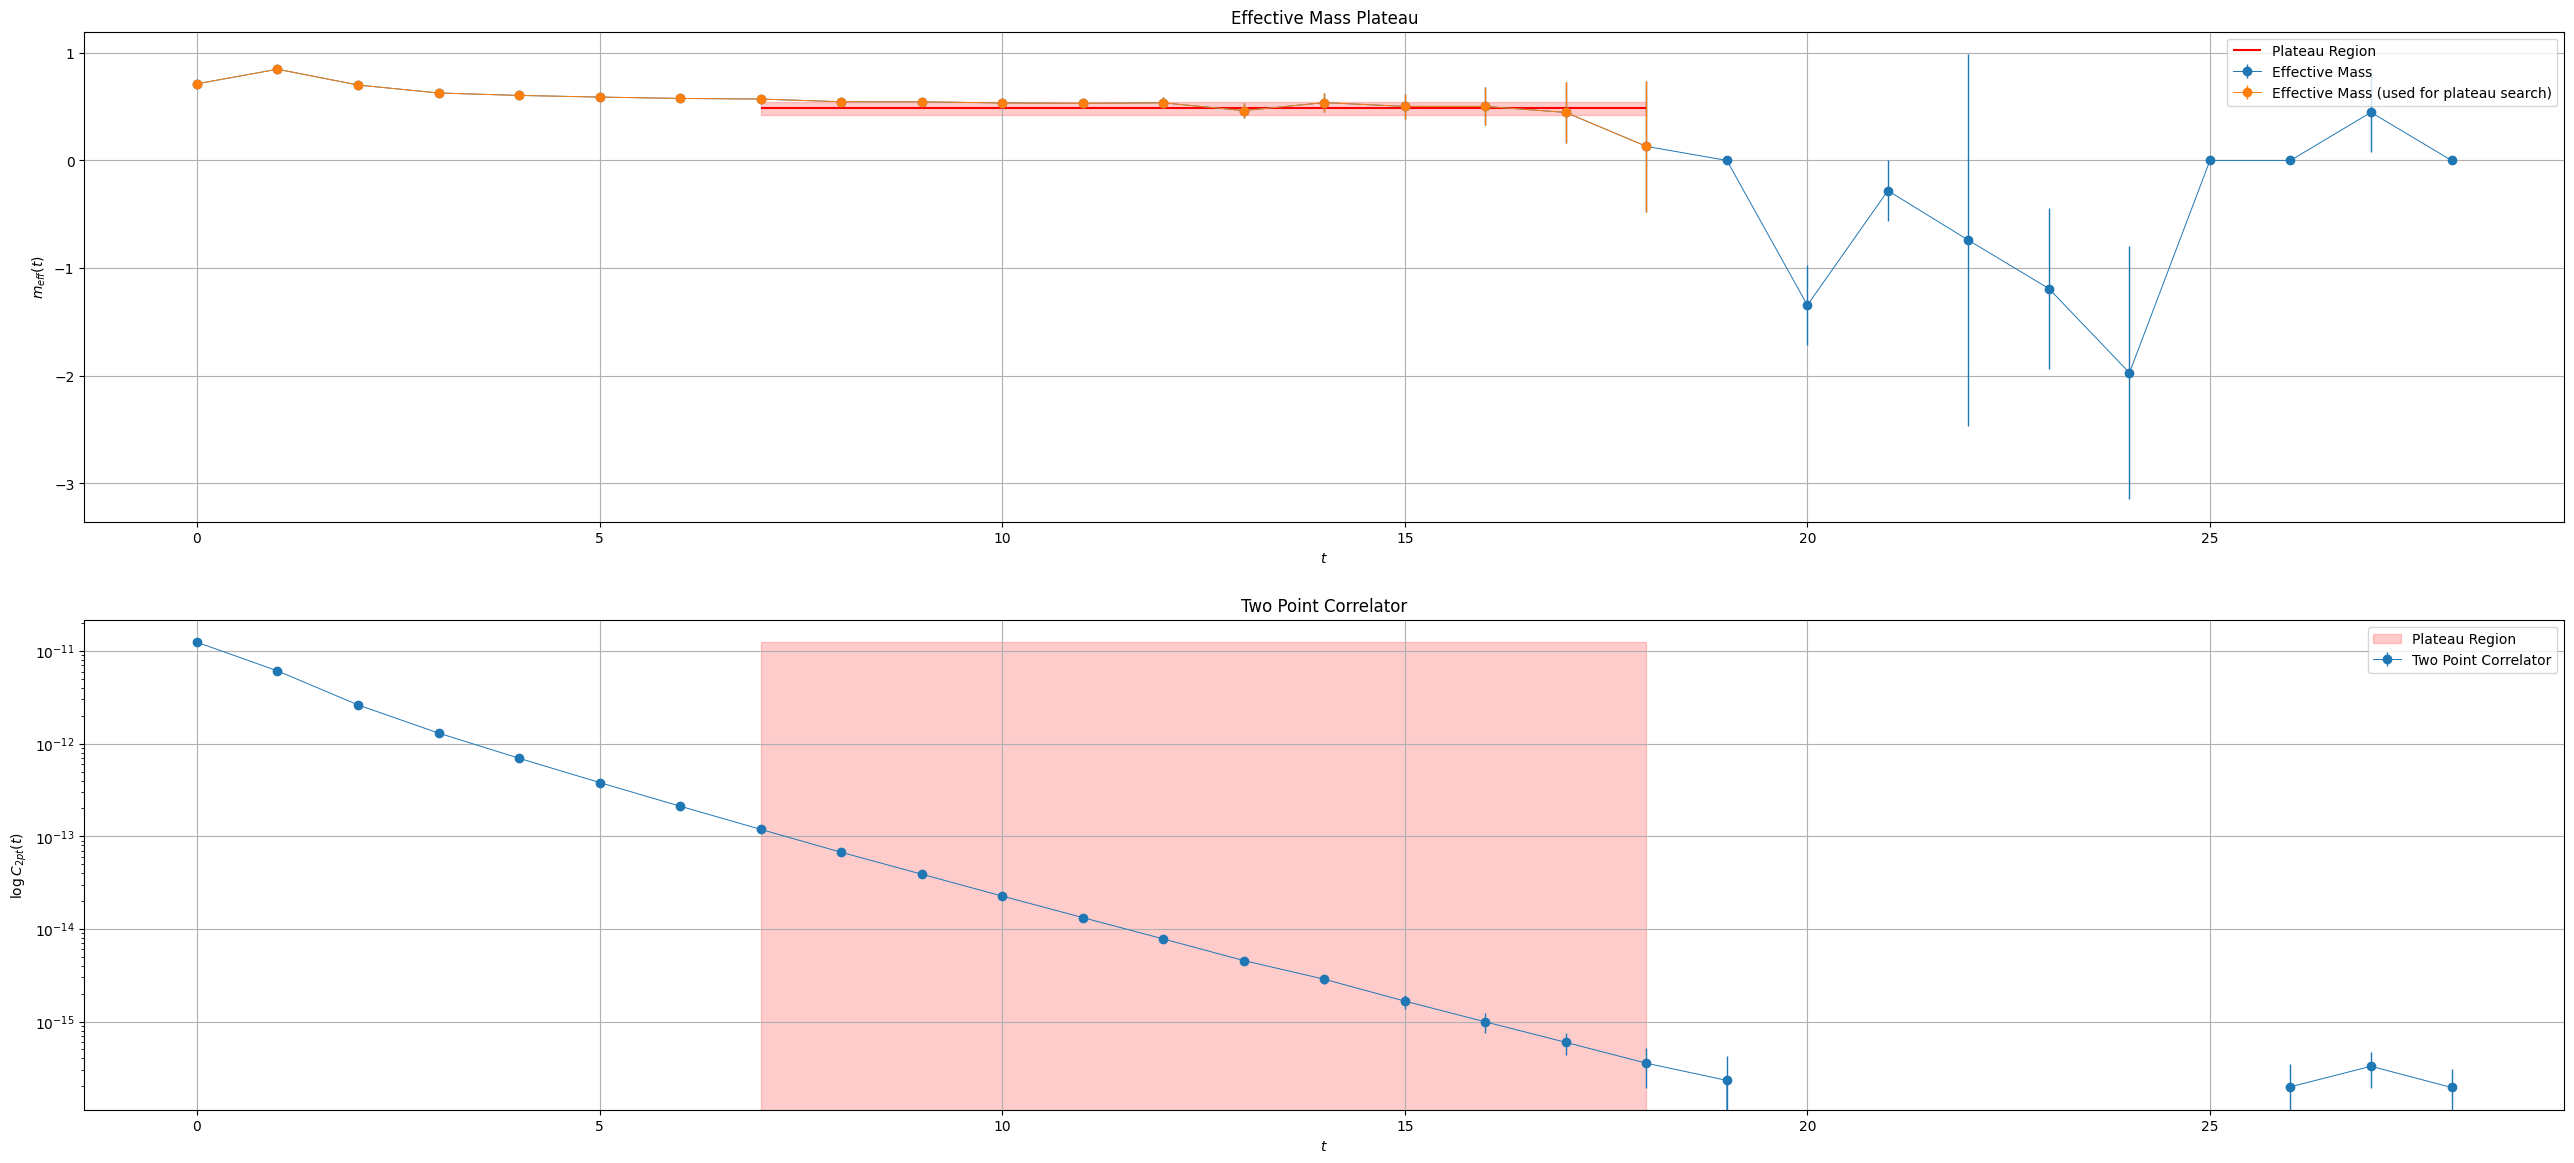

In [108]:
#we make a plot

#we instantiate the figure
fig, axlist = plt.subplots(nrows=2,ncols=1,figsize=(32, 14))

ax1 = axlist[0]


#we determine the time values to be displayed on the plot (x axis)
m_times = np.arange(np.shape(meff_raw)[0]) #+ 0.5

#we decide how much we want to zoom out of the plateau
zoom = 10

start_plot = start_plateau-zoom if start_plateau-zoom > 0 else 0

#we plot the plateau and the neighbouring effective mass values
_ = ax1.errorbar(m_times[start_plot:end_plateau+zoom], meff_raw[start_plot:end_plateau+zoom], yerr=meff_std_raw[start_plot:end_plateau+zoom], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass")
_ = ax1.errorbar( np.arange(np.shape(meff)[0]), meff, yerr=meff_std, linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass (used for plateau search)")
_ = ax1.hlines(gv_meff_mean.mean, start_plateau, end_plateau-1, color='red', label="Plateau Region")
#plt.hlines(meff_plat + meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
#plt.hlines(meff_plat - meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
_ = ax1.fill_between(m_times[start_plateau:end_plateau], gv_meff_mean.mean - gv_meff_mean.sdev, gv_meff_mean.mean + gv_meff_mean.sdev, alpha=0.2, color="red")

#plot styling
_ = ax1.set_title("Effective Mass Plateau")
_ = ax1.set_ylabel(r"$m_{eff}(t)$")
_ = ax1.set_xlabel(r"$t$")
_ = ax1.grid()
_ = ax1.legend()





ax2 = axlist[1]


#we determine the time values to be displayed on the plot (x axis)
times = np.arange(np.shape(p2corr_jack)[0]) #+ 0.5

#we decide how much we want to zoom out of the plateau
#zoom = 7

#we plot the plateau and the neighbouring effective mass values
_ = ax2.errorbar(times[start_plot:end_plateau+zoom], p2corr_jack[start_plot:end_plateau+zoom], yerr=p2corr_jack_std[start_plot:end_plateau+zoom], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Two Point Correlator")
#ax1.errorbar( np.arange(np.shape(meff)[0]), meff, yerr=meff_std, linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass (used for plateau search)")
#ax1.hlines(gv_meff_mean.mean, start_plateau, end_plateau-1, color='red', label="Plateau Region")
#plt.hlines(meff_plat + meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
#plt.hlines(meff_plat - meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
_ = ax2.fill_between(times[start_plateau:end_plateau], np.min(p2corr_jack[start_plot:end_plateau+zoom]), np.max(p2corr_jack[start_plot:end_plateau+zoom]), alpha=0.2, color="red", label="Plateau Region")

#plot styling
_ = ax2.set_title("Two Point Correlator")
_ = ax2.set_ylabel(r"$\log{C_{2pt}}(t)$")
_ = ax2.set_xlabel(r"$t$")
_ = ax2.set_yscale("log")
_ = ax2.grid()
_ = ax2.legend()

# 2 Point Correlator Fit

In [115]:
import correlatoranalyser as ca

In [ ]:
t_end = end_plateau # - 1
t_start = start_plateau

t_start, t_end

(7, 19)

In [111]:
#creation of jackknife resamples
binsize=1
jack_axis=0
first_conf=0
last_conf = np.shape(p2corr)[jack_axis]


#step 1: creation of the jackknife resamples
p2corr_resamples = np.asarray( [np.delete(p2corr, list(range(iconf,min(iconf+binsize,last_conf))) ,axis=jack_axis).mean(axis=0) for iconf in range(first_conf,last_conf,binsize)] ) #shape = (nresamp,) + shape(in_array) (with nconf -> nconf-binsize)

np.shape(p2corr_resamples)

(100, 48)

In [112]:
class SumOrderedExponentials:
    def __init__(self, number_states):
        self.number_states = number_states

    def __call__(self,t,p):
        E = p["E0"]
        out = p[f"A{0}"] * np.exp( -t*E )
    
        for n in range(1,self.number_states):
            #    ΔE_n = E_n - E_{n-1}
            # =>  E_n = E_{n-1} + ΔE_n
            E += p[f"dE{n}"]
    
            out += p[f"A{n}"] * np.exp( -t*E )
    
        return out

In [ ]:
prior = gv.BufferDict()

prior["A0"] = None #TO DO: add these variables
prior["E0"] = None
prior["A1"] = gv.gvar(1,1000)
prior["log(dE1)"] = gv.log(gv.gvar(1,1))
        

In [116]:
fit_result = ca.fit(

                    abscissa                = np.arange(t_start,t_end),
                    
                    ordinate_est            = np.mean(p2corr_resamples[:,t_start:t_end], axis = 0),
                    ordinate_std            = np.std (p2corr_resamples[:,t_start:t_end], axis = 0),
                    ordinate_cov            = np.cov (p2corr_resamples[:,t_start:t_end], rowvar=False),
                    
                    resample_ordinate_est   = p2corr_resamples[:,t_start:t_end],
                    resample_ordinate_std   = np.std (p2corr_resamples[:,t_start:t_end], axis = 0),
                    resample_ordinate_cov   = np.cov (p2corr_resamples[:,t_start:t_end], rowvar=False),

                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = True,
                    central_value_fit_correlated = False,

                    resample_fit                 = False,
                    resample_fit_correlated      = False,
                    
                    resample_fit_resample_prior  = False,
                    resample_type               = "jkn",

                    # args for lsqfit:
                    model   = SumOrderedExponentials(1),
                    prior   = None,
                    p0      = None,

                    svdcut  = None,
                    maxiter = 10_000,
)

ValueError: At least one of prior or p0 needs to be defined

In [ ]:
#params["C2pt fit"] = {
#    "shared": {
#        "min interval start": 1,
#        "interval end"      : 50,
#        "interval step"     : 4,
#        
#        "max number states": 2,
#        "model" : "sum of ordered exponentials",
#        
#        "central value fit": True,            
#        "central value fit correlated": False, 
#        "resample fit": True,     
#        "resample fit correlated": False,      
#        "resample prior": False,
#
#        "prior strategy": {
#            "Eeff": {
#                "estimate range start": 15,
#                "estimate range stop" : 50
#            },
#            "std scale": 3,
#            "mpi": gv.gvar("0.09203(16)")
#        }
#    }
#}